# WIDS Datathon 2020

**Paticipantes**: Adriana, Camila, Luiz, Michele

**Grupo Kaggle**: Ararajuba

**Ponto de atenção**: A variável "hospital_death" é a que devemos gerar a probabilidade em nosso modelo. As variáveis que começam com d1_ são exames clínicos acompanhados na primeira 24h do paciente na UTI e as variáveis h1_ são os exames clínicos acompanhados na primeira 1 hora do paciente na UTI, os valores h1_ possuem taxas acima de 90% de nulos em algumas features.

Métrica a ser encaminhada no resultado: AUC

Tipos de algoritimos comuns: **XGBoost, CatBoost, Random Forest.**

**DICA: Separe 5% dos dados para testes antes da subimição**

### Links/Fontes de informação

RISCO EM UTI: http://www.scielo.br/pdf/rbti/v28n3/0103-507X-rbti-28-03-0264.pdf

Notebooks da competição:
* https://www.kaggle.com/usharengaraju/wids2020-visualizingcategoricalfeatures
* https://www.kaggle.com/danofer/feature-selection-with-null-importances-wids

**Leitura IMPORTANTE** (MUST-DO): https://dspace.mit.edu/bitstream/handle/1721.1/112844/1015239594-MIT.pdf?sequence=1&isAllowed=y

## **Setup**

In [ ]:
# Pandas nos permite trabajar con DataFrames
import pandas as pd
# Para la visualización de datos
import plotly.express as px
import json
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# model
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier ,VotingClassifier

# roc curve and auc score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

%matplotlib inline
%load_ext google.colab.data_table

In [ ]:
!pip install mglearn
!pip install kaggle
!mkdir ~/.kaggle
!touch '/root/.kaggle/kaggle.json'
######################################################################################
# Copia aquí tu USER NAME y API KEY de kaggle

api_token = {"username":"xxxx","key":"xxxx"}
######################################################################################


with open('/root/.kaggle/kaggle.json', 'w') as file:
    json.dump(api_token, file)

!chmod 600 /root/.kaggle/kaggle.json

     |████████████████████████████████| 542kB 4.2MB/s 
  Created wheel for mglearn: filename=mglearn-0.1.7-py2.py3-none-any.whl size=582705 sha256=8117a2be6f76aec6daa075f8c19445c7fc9a3610934122db3f25425a3ec13f58
  Stored in directory: /root/.cache/pip/wheels/74/cf/8d/04f4932d15854a36726c6210763c7127e62de28f5c8ddfcf3b
Successfully built mglearn


In [ ]:
import mglearn

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning:

The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).

/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning:

sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.



In [ ]:
!kaggle competitions download -c widsdatathon2020

Traceback (most recent call last):
  File "/usr/local/bin/kaggle", line 5, in <module>
    from kaggle.cli import main
  File "/usr/local/lib/python2.7/dist-packages/kaggle/__init__.py", line 23, in <module>
    api.authenticate()
  File "/usr/local/lib/python2.7/dist-packages/kaggle/api/kaggle_api_extended.py", line 146, in authenticate
    self.config_file, self.config_dir))
IOError: Could not find kaggle.json. Make sure it's located in /root/.kaggle. Or use the environment method.


In [ ]:
!unzip -o training_v2.csv.zip 
!unzip -o unlabeled.csv.zip

Archive:  training_v2.csv.zip
  inflating: training_v2.csv         
Archive:  unlabeled.csv.zip
  inflating: unlabeled.csv           


In [ ]:
!ls

cache		       training_v2.csv.zip
sample_data	       unlabeled.csv
samplesubmission.csv   unlabeled.csv.zip
solution_template.csv  WiDS%20Datathon%202020%20Dictionary.csv
training_v2.csv


## **Exploratório**

In [ ]:
## Funções
def ler_arquivos(arquivo):
  df = pd.read_csv(arquivo)  
  print("Dimenções ",arquivo, "(filas, columnas)  : ", df.shape)
  return df

def remover_valores(df,column):
  df = df[(df[column].notnull())]
  print(df.shape)
  return df

def plot_roc_curve(fpr, tpr):
    plt.plot(fpr, tpr, color='orange', label='ROC')
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.show()

def missing_values(df):
  percent_missing_died = df[(df['hospital_death'] == 1) ].isnull().sum() * 100 / len(df)
  percent_missing_alive = df[(df['hospital_death'] == 0) ].isnull().sum() * 100 / len(df)
  missing_value_df = pd.DataFrame({'column_name': df.columns,
                                  'percent_missing_died': percent_missing_died,
                                  'percent_missing_alive': percent_missing_alive}).round(2)

  missing_value_df.sort_values('percent_missing_died', inplace=True)
  return missing_value_df.head(200)

def nan_values(df):
  percent_missing_died = df[(df['hospital_death'] == 1) ].isna().sum() * 100 / len(df)
  percent_missing_alive = df[(df['hospital_death'] == 0) ].isna().sum() * 100 / len(df)
  missing_value_df = pd.DataFrame({'column_name': df.columns,
                                  'percent_missing_died': percent_missing_died,
                                  'percent_missing_alive': percent_missing_alive}).round(2)

  missing_value_df.sort_values('percent_missing_died', inplace=True)
  return missing_value_df.head(200)

def fillnan_mean_ethnicity(df,column):
  gc = df.groupby(['ethnicity'],as_index=False).mean().round(2)

  for index, row in gc.iterrows():
    df.loc[df.ethnicity== row['ethnicity'],column] = df.loc[df.ethnicity== row['ethnicity'],column].fillna(gc[gc['ethnicity'] == row['ethnicity']][column].mean())
  return df

def fillnan_mean_age(df,column):
  if column in df:
    gc = df.groupby(['age'],as_index=False).mean().round(2)

    for index, row in gc.iterrows():
      df.loc[df.age== row['age'],column] = df.loc[df.age== row['age'],column].fillna(gc[gc['age'] == row['age']][column].mean())

  return df

def fillnan_mean_apache_3j_bodysystem(df,column):
  if column in df:
    gc = df.groupby(['apache_3j_bodysystem'],as_index=False).mean().round(2)

    for index, row in gc.iterrows():
      df.loc[df.apache_3j_bodysystem== row['apache_3j_bodysystem'],column] = df.loc[df.apache_3j_bodysystem== row['apache_3j_bodysystem'],column].fillna(gc[gc['apache_3j_bodysystem'] == row['apache_3j_bodysystem']][column].mean())
      
  return df

In [ ]:
df_training = ler_arquivos('training_v2.csv')
df_unlabeled = ler_arquivos('unlabeled.csv')
df_samplesubmission = ler_arquivos('samplesubmission.csv')
df_solution_template = ler_arquivos('solution_template.csv')
df_wids_dict = ler_arquivos('WiDS%20Datathon%202020%20Dictionary.csv')

Dimenções  training_v2.csv (filas, columnas)  :  (91713, 186)
Dimenções  unlabeled.csv (filas, columnas)  :  (39308, 186)
Dimenções  samplesubmission.csv (filas, columnas)  :  (3, 2)
Dimenções  solution_template.csv (filas, columnas)  :  (39308, 2)
Dimenções  WiDS%20Datathon%202020%20Dictionary.csv (filas, columnas)  :  (188, 6)


In [ ]:
from IPython.display import display
pd.set_option('display.max_columns', 100)
pd.options.display.max_columns = 100

cat_var = [key for key in dict(df_training.dtypes)
             if dict(df_training.dtypes)[key] in ['object'] ]

print('Features categoricas ',cat_var)

Features categoricas  ['ethnicity', 'gender', 'hospital_admit_source', 'icu_admit_source', 'icu_stay_type', 'icu_type', 'apache_3j_bodysystem', 'apache_2_bodysystem']


In [ ]:
replace_map = {'apache_3j_bodysystem': {'Cardiovascular': 1, 'Sepsis': 2, 'Respiratory': 3, 'Neurological': 4,'Gastrointestinal': 5,'Metabolic': 6
                                      , 'Trauma': 7, 'Genitourinary ': 8, 'Musculoskeletal/Skin': 9,'Hematological': 10, 'Gynecological': 11}}
labels = df_training['apache_3j_bodysystem'].astype('category').cat.categories.tolist()
replace_map_comp = {'apache_3j_bodysystem' : {k: v for k,v in zip(labels,list(range(1,len(labels)+1)))}}

df_training.replace(replace_map_comp, inplace=True)
df_unlabeled.replace(replace_map_comp, inplace=True)

In [ ]:
replace_map = {'icu_type': {'Med-Surg ICU': 1, 'MICU': 2, 'Neuro ICU': 3, 'CCU-CTICU': 4, 'SICU': 5, 'Cardiac ICU': 6, 'CSICU': 7, 'CTICU': 8}}
labels = df_training['icu_type'].astype('category').cat.categories.tolist()
replace_map_comp = {'icu_type' : {k: v for k,v in zip(labels,list(range(1,len(labels)+1)))}}

df_training.replace(replace_map_comp, inplace=True)
df_unlabeled.replace(replace_map_comp, inplace=True)

In [ ]:
replace_map = {'icu_stay_type': {'admit': 1, 'transfer': 2, 'readmit': 3}}
labels = df_training['icu_stay_type'].astype('category').cat.categories.tolist()
replace_map_comp = {'icu_stay_type' : {k: v for k,v in zip(labels,list(range(1,len(labels)+1)))}}

df_training.replace(replace_map_comp, inplace=True)
df_unlabeled.replace(replace_map_comp, inplace=True)

In [ ]:
replace_map = {'icu_admit_source': {'Accident & Emergency': 1, 'Floor': 2, 'Operating Room / Recovery': 3, 'Other Hospital': 4,'Other ICU': 5}}
labels = df_training['icu_admit_source'].astype('category').cat.categories.tolist()
replace_map_comp = {'icu_admit_source' : {k: v for k,v in zip(labels,list(range(1,len(labels)+1)))}}

df_training.replace(replace_map_comp, inplace=True)
df_unlabeled.replace(replace_map_comp, inplace=True)

In [ ]:
replace_map = {'hospital_admit_source': {'Emergency Department': 1, 'Floor': 2, 'Operating Room': 3, 'Direct Admit': 4,'Recovery Room': 5,'Acute Care/Floor': 6,'Other Hospital': 7,'Step-Down Unit (SDU)': 8,'PACU': 9,'Chest Pain Center': 10,'ICU to SDU': 11,'ICU': 12,'Other ICU': 13,'Observation': 14,'Other': 15}}
labels = df_training['hospital_admit_source'].astype('category').cat.categories.tolist()
replace_map_comp = {'hospital_admit_source' : {k: v for k,v in zip(labels,list(range(1,len(labels)+1)))}}

df_training.replace(replace_map_comp, inplace=True)
df_unlabeled.replace(replace_map_comp, inplace=True)

In [ ]:
replace_map = {'ethnicity': {'Caucasian': 1, 'African American': 2, 'Hispanic': 3, 'Asian': 4,'Native American': 5,'Other/Unknown': 6}}
labels = df_training['ethnicity'].astype('category').cat.categories.tolist()
replace_map_comp = {'ethnicity' : {k: v for k,v in zip(labels,list(range(1,len(labels)+1)))}}

df_training.replace(replace_map_comp, inplace=True)
df_unlabeled.replace(replace_map_comp, inplace=True)

In [ ]:
replace_map = {'apache_2_bodysystem': {'Cardiovascular': 1, 'Neurologic': 2, 'Respiratory': 3, 'Gastrointestinal': 4,'Metabolic': 5,'Trauma': 6
                                      , 'Renal/Genitourinary': 7, 'Haematologic': 8, 'Undefined Diagnoses': 9,'Undefined diagnoses': 9}}
labels = df_training['apache_2_bodysystem'].astype('category').cat.categories.tolist()
replace_map_comp = {'apache_2_bodysystem' : {k: v for k,v in zip(labels,list(range(1,len(labels)+1)))}}

df_training.replace(replace_map_comp, inplace=True)
df_unlabeled.replace(replace_map_comp, inplace=True)

In [ ]:
replace_map = {'gender': {'M': 0, 'F': 1}}
labels = df_training['gender'].astype('category').cat.categories.tolist()
replace_map_comp = {'gender' : {k: v for k,v in zip(labels,list(range(1,len(labels)+1)))}}

df_training.replace(replace_map_comp, inplace=True)
df_unlabeled.replace(replace_map_comp, inplace=True)

In [ ]:
# Sobrevivente (0) Óbito (1)
df_training["gender"].value_counts(normalize=True)

2.0    0.539536
1.0    0.460464
Name: gender, dtype: float64

In [ ]:
df_training = remover_valores(df_training,'gender')               # Retira registros sem genero equivalente a 0.01 (obito)
df_training = remover_valores(df_training,'icu_admit_source')     # Retira registros sem id de localizacao do atendimento na UTI
df_training = remover_valores(df_training,'d1_heartrate_min')     # Retira registros sem informacao de Heart Rate e que continham valores de probabilidade negativos
df_training = remover_valores(df_training,'d1_mbp_max')           # Retira registros sem informacao de monitotramento de pressao do sangue pelas primeiras 24hs
df_training = remover_valores(df_training,'ethnicity')            # Retira regitros sem coleta de cultura ou nacionalidade do paciente 
df_training = remover_valores(df_training,'d1_sysbp_max')         # Retira registros sem coleta da pressao arterial simbolica mais alta entre as 24hrs
df_training = remover_valores(df_training,'d1_sysbp_min')         # Retira registros sem coleta da pressao arterial simbolica mais baixa entre as 24hrs
df_training = remover_valores(df_training,'d1_diasbp_max')        # Retira registros sem coleta da pressao arterial diastolica mais alta entre as 24hrs
df_training = remover_valores(df_training,'d1_diasbp_min')        # Retira registros sem coleta da pressao arterial diastolica mais baixa entre as 24hrs
df_training = remover_valores(df_training,'apache_3j_bodysystem') # Retira registros sem classificacao de internacao Apache III 
df_training = remover_valores(df_training,'age')                  # Retira registros sem idade

(91688, 186)
(91576, 186)
(91435, 186)
(91337, 186)
(89978, 186)
(89966, 186)
(89966, 186)
(89962, 186)
(89962, 186)
(88411, 186)
(84986, 186)


In [ ]:
#print(df_training["age"].value_counts(normalize=True),'\n')
df_training.age.unique()

array([68., 77., 25., 81., 19., 67., 59., 70., 45., 72., 80., 48., 65.,
       78., 30., 46., 79., 58., 87., 60., 85., 76., 53., 71., 82., 52.,
       75., 64., 55., 73., 88., 84., 62., 56., 38., 41., 35., 54., 74.,
       49., 86., 51., 63., 61., 47., 33., 89., 50., 36., 69., 57., 22.,
       83., 66., 42., 27., 18., 17., 37., 43., 28., 40., 20., 32., 34.,
       23., 44., 24., 39., 26., 31., 29., 21., 16.])

In [ ]:
#Apagar columas sem valores no cross_validation 
#Todos os registros sao iguais
df_training = df_training.drop('readmission_status', 1)

In [ ]:
# Retira registros com probabilidade negativa, representa 153 registros com obito e 1564 alta
#df_training = df_training[                                                      
#            (df_training['apache_4a_hospital_death_prob'] > 0) 
#          & (df_training['apache_4a_icu_death_prob'] > 0 )
#]
print(df_training.shape)

(84986, 185)


In [ ]:
percent_missing_died = df_training[(df_training['hospital_death'] == 1) ].isnull().sum() * 100 / len(df_training)
percent_missing_alive = df_training[(df_training['hospital_death'] == 0) ].isnull().sum() * 100 / len(df_training)
missing_value_df = pd.DataFrame({'column_name': df_training.columns,
                                 'percent_missing_died': percent_missing_died,
                                 'percent_missing_alive': percent_missing_alive}).round(2)

missing_value_df.sort_values('percent_missing_died', inplace=True)

missing_value_df[(missing_value_df["column_name"] == 'gcs_unable_apache') 
#                | (missing_value_df["column_name"] == 'h1_creatinine_max')
#                | (missing_value_df["column_name"] == 'd1_creatinine_min')
#                | (missing_value_df["column_name"] == 'd1_creatinine_max')
              ]
missing_value_df.head(200)

,column_name,percent_missing_died,percent_missing_alive
encounter_id,encounter_id,0.00,0.00
ventilated_apache,ventilated_apache,0.00,0.00
d1_diasbp_max,d1_diasbp_max,0.00,0.00
d1_diasbp_min,d1_diasbp_min,0.00,0.00
d1_heartrate_max,d1_heartrate_max,0.00,0.00
...,...,...,...
h1_diasbp_invasive_max,h1_diasbp_invasive_max,6.97,74.41
h1_albumin_max,h1_albumin_max,7.15,84.12
h1_albumin_min,h1_albumin_min,7.15,84.12
h1_bilirubin_min,h1_bilirubin_min,7.27,84.87


## **Tratamento valores NAN**

In [ ]:
# Sobrevivente (0) Óbito (1)
df_training["hospital_death"].value_counts(normalize=True)

0    0.916363
1    0.083637
Name: hospital_death, dtype: float64

### Dica sobre Missing Vlues

There's no guarantee that a column with 60% missing values wouldn't be useful to your model. I wouldn't drop it before evaluating the feature. Best bet is to just build a model with the column, check the model's feature importance for that variable. If it doesn't seem important, then try dropping the column and see how that changes your score in cross validation.

Os gráficos de cross_validation abaixo serão utilizados para analisar as colunas e suas correlações, o objetivo é retirar o maior número de colunas com valores nulos e que não geram valor para o modelo. **A última coluna é a variável target**

Nesta etapa é selecionado apenas as TOP 40 features relacionadas a feature **target** (20 relacionados a óbito e 20 relacionadas a alta)

In [ ]:
df = df_training

target = df_training['hospital_death']

df.drop('hospital_death', axis=1, inplace=True)
df.insert(len(df.columns), 'hospital_death', target)

#get correlations of each features in dataset
corrmat = df.corr(method ='pearson')

df_correlacao_negativa = corrmat.sort_values("hospital_death", ascending=True)
df_corr_top_sobreviveu = df_correlacao_negativa.head(80)

df_correlacao_positiva = corrmat.sort_values("hospital_death", ascending=False)
df_corr_top_morreu = df_correlacao_positiva.head(80)

print("Top 40 features Morreu: ", df_corr_top_morreu.index)
print("Top 40 features Sobreviveu: ", df_corr_top_sobreviveu.index)

Top 40 features Morreu:  Index(['hospital_death', 'd1_lactate_min', 'd1_lactate_max', 'h1_lactate_min',
       'apache_4a_hospital_death_prob', 'h1_lactate_max',
       'apache_4a_icu_death_prob', 'ventilated_apache', 'fio2_apache',
       'd1_inr_max', 'h1_inr_max', 'd1_bun_max', 'bun_apache', 'd1_bun_min',
       'intubated_apache', 'h1_inr_min', 'd1_inr_min', 'h1_bun_max',
       'h1_bun_min', 'd1_heartrate_max', 'd1_wbc_max', 'bilirubin_apache',
       'd1_bilirubin_max', 'h1_bilirubin_max', 'h1_bilirubin_min',
       'wbc_apache', 'd1_bilirubin_min', 'd1_wbc_min', 'h1_resprate_max',
       'd1_creatinine_max', 'creatinine_apache', 'h1_heartrate_max',
       'h1_creatinine_max', 'h1_creatinine_min', 'd1_potassium_max', 'age',
       'heart_rate_apache', 'h1_resprate_min', 'd1_creatinine_min',
       'd1_resprate_max', 'h1_heartrate_min', 'h1_potassium_min',
       'resprate_apache', 'd1_glucose_max', 'h1_potassium_max', 'h1_wbc_max',
       'h1_wbc_min', 'glucose_apache', 'pre_icu_

Após o filtro das colunas mais importantes avaliamos quais features estão com valores nulos

In [ ]:
#Selecionar as features com maior e menor correlacao (40 mais features importantes)
df_training_filted = pd.DataFrame()

index_values = df_corr_top_morreu.index 
index_values = index_values.append(df_corr_top_sobreviveu.index)
index_add = pd.Index(["encounter_id","age","gender","ethnicity","apache_3j_bodysystem","hospital_admit_source","icu_admit_source","icu_stay_type"])
index_values = index_values.append(index_add)

index_values = index_values.unique()
index_values = index_values.to_list()

df_training_filted = df_training.filter(index_values, axis=1)
df_unlabeled_filted = df_unlabeled.filter(index_values, axis=1)

ms = missing_values(df_training_filted)
ms

,column_name,percent_missing_died,percent_missing_alive
hospital_death,hospital_death,0.00,0.00
pre_icu_los_days,pre_icu_los_days,0.00,0.00
solid_tumor_with_metastasis,solid_tumor_with_metastasis,0.00,0.00
apache_3j_bodysystem,apache_3j_bodysystem,0.00,0.00
immunosuppression,immunosuppression,0.00,0.00
...,...,...,...
h1_diasbp_invasive_min,h1_diasbp_invasive_min,6.97,74.41
h1_albumin_min,h1_albumin_min,7.15,84.12
h1_albumin_max,h1_albumin_max,7.15,84.12
h1_bilirubin_min,h1_bilirubin_min,7.27,84.87


Montamos também um gráfico de cross_validation pelas principais features.

In [ ]:
df = df_training_filted

target = df_training_filted['hospital_death']

#get correlations of each features in dataset
corrmat = df.corr(method ='pearson')
top_corr_features = corrmat.index
plt.figure(figsize=(60,60))
#plot heat map
g=sns.heatmap(df[top_corr_features].corr(),annot=True,cmap="RdYlGn")

Output hidden; open in https://colab.research.google.com to view.

Avaliar balanceamento

In [ ]:
print(df_training_filted.shape)
print(df_unlabeled_filted.shape)

(84986, 163)
(39308, 163)


In [ ]:
# Sobrevivente (0) Óbito (1)
df_training_filted["hospital_death"].value_counts()

0    77878
1     7108
Name: hospital_death, dtype: int64

# **Aplicação de Modelo**

Notebook ref.: https://www.kaggle.com/usharengaraju/wids2020-ensemblelearning-votingclassifier

Algoritimos de ML: https://machinelearningmastery.com/metrics-evaluate-machine-learning-algorithms-python/

### **Primeiro Modelo**

In [ ]:
#Primeiro modelo
df_training_test = df_training_filted 

# Remover valores que predominavam em nulo para sobreviventes - com o objetivo de balancear melhor os dados para o modelo
df_training_test = remover_valores(df_training_filted,'h1_albumin_min') 
df_training_test = remover_valores(df_training_test,'h1_albumin_max')
df_training_test = remover_valores(df_training_test,'d1_arterial_ph_min')
df_training_test = remover_valores(df_training_test,'h1_lactate_min')
df_training_test = remover_valores(df_training_test,'h1_lactate_max')

(6300, 126)
(6300, 126)
(3400, 126)
(1566, 126)
(1566, 126)


## **Segundo Modelo**

In [ ]:
#Segundo modelo
df_training_test = df_training_filted 

# Remover valores que predominavam em nulo para sobreviventes - com o objetivo de balancear melhor os dados para o modelo
df_training_test = remover_valores(df_training_filted,'h1_albumin_min') 
df_training_test = remover_valores(df_training_test,'h1_albumin_max')

print('Shape:',df_training_test.shape)

(6300, 126)
(6300, 126)
Shape: (6300, 126)


## **Terceiro Modelo**

In [ ]:
#Terceiro modelo
df_training_test = df_training_filted 
df_unlabeled_test = df_unlabeled_filted 

print('Shape:',df_training_test.shape)
print('Shape:',df_unlabeled_test.shape)

Shape: (91713, 87)
Shape: (39308, 87)


In [ ]:
#df_training_test[['h1_mbp_invasive_max',"gender"]].groupby(["gender"], as_index=True).mean().sort_values(by="h1_mbp_invasive_max").plot.bar()
#df_training_test[['h1_mbp_invasive_max',"age"]].groupby(["age"], as_index=True).mean().sort_values(by="h1_mbp_invasive_max").plot.bar()
#df_training_test[['h1_mbp_invasive_max',"ethnicity"]].groupby(["ethnicity"], as_index=True).mean().sort_values(by="h1_mbp_invasive_max").plot.bar()

#df_unlabeled[['gcs_eyes_apache',"apache_2_bodysystem"]].groupby(["apache_2_bodysystem"], as_index=True).mean().sort_values(by="gcs_eyes_apache").plot.bar()

In [ ]:
def normalizar_dataset(df,drop_columns):

  df = df.drop(drop_columns,axis = 1)

  #Exames fisiologicos - Primeira hora
  df = fillnan_mean_age(df,"h1_lactate_max")
  df = fillnan_mean_age(df,"h1_lactate_min")
  df = fillnan_mean_age(df,"h1_bilirubin_max")
  df = fillnan_mean_age(df,"h1_bilirubin_min")
  df = fillnan_mean_age(df,"h1_pao2fio2ratio_max")
  df = fillnan_mean_age(df,"h1_pao2fio2ratio_min")
  df = fillnan_mean_age(df,"h1_creatinine_max")
  df = fillnan_mean_age(df,"h1_creatinine_min")
  df = fillnan_mean_age(df,"h1_bun_max")
  df = fillnan_mean_age(df,"h1_bun_min")
  df = fillnan_mean_age(df,"h1_diasbp_invasive_max")
  df = fillnan_mean_age(df,"h1_diasbp_invasive_min")
  
  #Exames fisiologicos - Primeira 24 horas
  df = fillnan_mean_age(df,"d1_lactate_max")
  df = fillnan_mean_age(df,"d1_lactate_min")
  df = fillnan_mean_age(df,"d1_bilirubin_max")
  df = fillnan_mean_age(df,"d1_bilirubin_min")
  df = fillnan_mean_age(df,"d1_pao2fio2ratio_max")
  df = fillnan_mean_age(df,"d1_pao2fio2ratio_min")
  df = fillnan_mean_age(df,"d1_creatinine_max")
  df = fillnan_mean_age(df,"d1_creatinine_min")
  df = fillnan_mean_age(df,"d1_bun_max")
  df = fillnan_mean_age(df,"d1_bun_min")
  df = fillnan_mean_age(df,"d1_diasbp_invasive_max")
  df = fillnan_mean_age(df,"d1_diasbp_invasive_min")

  #Features individuais scores
  df = fillnan_mean_age(df,"urineoutput_apache")
  df = fillnan_mean_age(df,"bilirubin_apache")
  df = fillnan_mean_age(df,"ventilated_apache")
  df = fillnan_mean_age(df,"intubated_apache")
  df = fillnan_mean_age(df,"pre_icu_los_days")

  # Score de Glasgow
  df = fillnan_mean_age(df,"gcs_motor_apache")
  df = fillnan_mean_age(df,"gcs_eyes_apache")
  df = fillnan_mean_age(df,"gcs_verbal_apache")
    
  df['gcs_sum'] = (df['gcs_motor_apache'] + df['gcs_eyes_apache'] + df['gcs_verbal_apache'])
  df['gcs_intubated'] = np.where(df['gcs_sum']<=8, 1, 0)
  df = df.drop('gcs_sum',axis = 1)

  return df

In [ ]:
ms = missing_values(df_training_test)
index_to_drop = ms[ms["percent_missing_alive"] > 75].index

df_training_test = normalizar_dataset(df_training_test,index_to_drop)
df_unlabeled_test = normalizar_dataset(df_unlabeled_test,index_to_drop)
print(df_training_test.shape)
print(df_unlabeled_test.shape)

(66987, 162)
(39308, 162)


In [ ]:
ms = missing_values(df_training_test)
ms

,column_name,percent_missing_died,percent_missing_alive
hospital_death,hospital_death,0.00,0.00
d1_heartrate_min,d1_heartrate_min,0.00,0.00
gender,gender,0.00,0.00
encounter_id,encounter_id,0.00,0.00
hospital_id,hospital_id,0.00,0.00
...,...,...,...
h1_hematocrit_min,h1_hematocrit_min,7.29,72.38
h1_platelets_min,h1_platelets_min,7.56,74.67
h1_platelets_max,h1_platelets_max,7.56,74.67
h1_wbc_min,h1_wbc_min,7.60,74.97


In [ ]:
ms = missing_values(df_training_test)
index_to_fillnan = ms[ms["percent_missing_alive"] > 0].index

index_to_fillnan

Index(['d1_resprate_min', 'd1_resprate_max', 'd1_spo2_max', 'd1_spo2_min',
       'd1_sysbp_noninvasive_max', 'd1_diasbp_noninvasive_min',
       'd1_sysbp_noninvasive_min', 'd1_diasbp_noninvasive_max',
       'd1_mbp_noninvasive_min', 'd1_mbp_noninvasive_max', 'height',
       'h1_heartrate_min', 'h1_heartrate_max', 'weight', 'h1_diasbp_max',
       'h1_sysbp_min', 'h1_sysbp_max', 'h1_diasbp_min', 'd1_temp_max',
       'd1_temp_min', 'h1_mbp_max', 'h1_mbp_min', 'h1_resprate_min',
       'h1_resprate_max', 'bmi', 'h1_spo2_max', 'h1_spo2_min',
       'd1_glucose_max', 'd1_glucose_min', 'temp_apache',
       'h1_sysbp_noninvasive_min', 'h1_sysbp_noninvasive_max',
       'h1_diasbp_noninvasive_max', 'h1_diasbp_noninvasive_min',
       'h1_mbp_noninvasive_min', 'h1_mbp_noninvasive_max', 'd1_sodium_max',
       'd1_sodium_min', 'glucose_apache', 'd1_potassium_min',
       'd1_potassium_max', 'd1_hematocrit_max', 'd1_hematocrit_min',
       'd1_hemaglobin_max', 'd1_hemaglobin_min', 'd1_calci

In [ ]:
#Substituir todas com valores pela média da idade
df = df_training_test
for x in index_to_fillnan:
  df = fillnan_mean_age(df,x)

df_training_test = df

#Substituir todas com valores pela média da idade
df = df_unlabeled_test
for x in index_to_fillnan:
  df = fillnan_mean_age(df,x)

df_unlabeled_test = df

In [ ]:
#df_training_test = remover_valores(df_training_test,'d1_albumin_max') 
#df_training_test = remover_valores(df_training_test,'d1_albumin_min') 

In [ ]:
ms = missing_values(df_training_test)
ms

,column_name,percent_missing_died,percent_missing_alive
hospital_death,hospital_death,0.0,0.0
apache_2_bodysystem,apache_2_bodysystem,0.0,0.0
paco2_for_ph_apache,paco2_for_ph_apache,0.0,0.0
paco2_apache,paco2_apache,0.0,0.0
d1_hemaglobin_max,d1_hemaglobin_max,0.0,0.0
...,...,...,...
arf_apache,arf_apache,0.0,0.0
d1_glucose_min,d1_glucose_min,0.0,0.0
d1_arterial_pco2_max,d1_arterial_pco2_max,0.0,0.0
h1_potassium_min,h1_potassium_min,0.0,0.0


## **Quarto Modelo**

Link: http://www.limic.xpg.com.br/aulas%20downloa/Exames%20laboratoriais%20de%20rotina%20em%20UTI.pdf

Neste link está informado algumas informações importantes:

- Problemas com função Renal os esxames mais importantes: Uréia e creatinina e este exame muda conforme idade (jovens/idosos - c/ 50%) a creatinida também sobre influencia em relação a alimentação. já a uréia tem alta correlação com o problema que o internou na UTI. Valor normal: 0,6 a 1,3 (Existe um calculo que envolve peso e idade e genero)

  - Potássio é importante para o funcionamento das células nervosas. Valor normal: 3,5 a 5,5

  - Hipocalemia: menor que 3,5mEq/L resulta em 20% dos pacientes internado (cenário Brasil) - Vômitos recorrentes, diarréia, alcalose metabólica.

  - Hipercalermia: maior que 5,5mEq/L - Distúrbio menos comum que a hipocalemia, mas de grande gravidade.hipocalemia, mas de grande **gravidade**. (IRA e IRC) - Alterações do ECG e (K+> 6,0mEq/l > 6,0mEq/l -- Instal aguda)

  - Sódio (principal medida para identificar a osmolaridade plasm.) - Valor Normal: 135--145mEq/L145mEq/L

- Hemograma: consiste em avaliações de células do sangue e que é dividido em três grupos:

  - Eritrocítos (vermelha)
  - Leucocítos  (branca)
  - Plaquetas   (plaquetária)

  No nosso dataset: (d1_hemaglobin_max) e seus valores de ref. mudam conforme o sexo

- Hemoglobina: Função principal, análise de anemia os limites inferiores são:
  - Homens adultos                  13 (g/dL)
  - Mulher adultas e crianças       12 (g/dL)
  - Gestantes                       11 (g/dL)

- Plaquetograma: Valor Normal:140.000 –– 500.000 - Plaquetose: Inflamação, anemia, pós-operatorio.

- Glicemia: (d1_glucose_max e glucose_apache) - Na UTI deve ser normalizado, no link acima cita que deve ser avitado a todo custo altos níveis de glicemia como baixos níveis. (8 horas de jejum)
  - Valor normal: < 99 mg/dL
  - Pré-diabete: > 99 a 125 mg/dL
  - Diabetes: > 126 mg/dL (dois dias diferentes) - 




In [ ]:
#apache_3j_bodysystem
#Terceiro modelo
df_training_test = df_training_filted 
df_unlabeled_test = df_unlabeled_filted 

print('Shape:',df_training_test.shape)
print('Shape:',df_unlabeled_test.shape)

Shape: (84986, 163)
Shape: (39308, 163)


In [ ]:
print('Morreu com alteracao na glicose ',df_training_test[(df_training_test['d1_glucose_max'] > 125) & (df_training_test['hospital_death'] == 1)].hospital_death.count())
print('Morreu sem alteracao na glicose ',df_training_test[(df_training_test['d1_glucose_max'] < 125) & (df_training_test['hospital_death'] == 1)].hospital_death.count())

Morreu com alteracao na glicose  5358
Morreu sem alteracao na glicose  1319


In [ ]:
#d1_creatinine_max
print('Morreu com alteracao creatinina ',df_training_test[((df_training_test['d1_creatinine_max'] < 0.6) | (df_training_test['d1_creatinine_max'] > 1.3)) & (df_training_test['hospital_death'] == 1)].hospital_death.count())
print('Morreu sem alteracao creatinina ',df_training_test[((df_training_test['d1_creatinine_max'] > 0.6) | (df_training_test['d1_creatinine_max'] < 1.3)) & (df_training_test['hospital_death'] == 1)].hospital_death.count())

Morreu com alteracao creatinina  4119
Morreu sem alteracao creatinina  6399


In [ ]:
def normalizar_dataset(df,drop_columns):

  df = df.drop(drop_columns,axis = 1)

  #Exames fisiologicos - Primeira hora
  df = fillnan_mean_apache_3j_bodysystem(df,"h1_lactate_max")
  df = fillnan_mean_apache_3j_bodysystem(df,"h1_lactate_min")
  df = fillnan_mean_apache_3j_bodysystem(df,"h1_bilirubin_max")
  df = fillnan_mean_apache_3j_bodysystem(df,"h1_bilirubin_min")
  df = fillnan_mean_apache_3j_bodysystem(df,"h1_pao2fio2ratio_max")
  df = fillnan_mean_apache_3j_bodysystem(df,"h1_pao2fio2ratio_min")
  df = fillnan_mean_apache_3j_bodysystem(df,"h1_creatinine_max")
  df = fillnan_mean_apache_3j_bodysystem(df,"h1_creatinine_min")
  df = fillnan_mean_apache_3j_bodysystem(df,"h1_bun_max")
  df = fillnan_mean_apache_3j_bodysystem(df,"h1_bun_min")
  df = fillnan_mean_apache_3j_bodysystem(df,"h1_diasbp_invasive_max")
  df = fillnan_mean_apache_3j_bodysystem(df,"h1_diasbp_invasive_min")
  
  #Exames fisiologicos - Primeira 24 horas
  df = fillnan_mean_apache_3j_bodysystem(df,"d1_lactate_max")
  df = fillnan_mean_apache_3j_bodysystem(df,"d1_lactate_min")
  df = fillnan_mean_apache_3j_bodysystem(df,"d1_bilirubin_max")
  df = fillnan_mean_apache_3j_bodysystem(df,"d1_bilirubin_min")
  df = fillnan_mean_apache_3j_bodysystem(df,"d1_pao2fio2ratio_max")
  df = fillnan_mean_apache_3j_bodysystem(df,"d1_pao2fio2ratio_min")
  df = fillnan_mean_apache_3j_bodysystem(df,"d1_creatinine_max")
  df = fillnan_mean_apache_3j_bodysystem(df,"d1_creatinine_min")
  df = fillnan_mean_apache_3j_bodysystem(df,"d1_bun_max")
  df = fillnan_mean_apache_3j_bodysystem(df,"d1_bun_min")
  df = fillnan_mean_apache_3j_bodysystem(df,"d1_diasbp_invasive_max")
  df = fillnan_mean_apache_3j_bodysystem(df,"d1_diasbp_invasive_min")

  #Features individuais scores
  df = fillnan_mean_apache_3j_bodysystem(df,"urineoutput_apache")
  df = fillnan_mean_apache_3j_bodysystem(df,"bilirubin_apache")
  df = fillnan_mean_apache_3j_bodysystem(df,"ventilated_apache")
  df = fillnan_mean_apache_3j_bodysystem(df,"intubated_apache")
  df = fillnan_mean_apache_3j_bodysystem(df,"pre_icu_los_days")

  # Score de Glasgow
  df = fillnan_mean_apache_3j_bodysystem(df,"gcs_motor_apache")
  df = fillnan_mean_apache_3j_bodysystem(df,"gcs_eyes_apache")
  df = fillnan_mean_apache_3j_bodysystem(df,"gcs_verbal_apache")
    
  df['gcs_sum'] = (df['gcs_motor_apache'] + df['gcs_eyes_apache'] + df['gcs_verbal_apache'])
  df['gcs_intubated'] = np.where(df['gcs_sum']<=8, 1, 0)

  df['higth_d1_glucose_max'] = np.where(df['d1_glucose_max']>125, 1, 0)

  df = df.drop('gcs_sum',axis = 1)

  return df

In [ ]:
ms = missing_values(df_training_test)
index_to_drop = ms[ms["percent_missing_alive"] > 75].index

df_training_test = normalizar_dataset(df_training_test,index_to_drop)
df_unlabeled_test = normalizar_dataset(df_unlabeled_test,index_to_drop)
print(df_training_test.shape)
print(df_unlabeled_test.shape)

(84986, 144)
(39308, 144)


In [ ]:
ms = missing_values(df_training_test)
ms

,column_name,percent_missing_died,percent_missing_alive
hospital_death,hospital_death,0.00,0.00
gcs_motor_apache,gcs_motor_apache,0.00,0.00
patient_id,patient_id,0.00,0.00
d1_diasbp_max,d1_diasbp_max,0.00,0.00
ethnicity,ethnicity,0.00,0.00
...,...,...,...
h1_hemaglobin_min,h1_hemaglobin_min,6.26,73.11
h1_hemaglobin_max,h1_hemaglobin_max,6.26,73.11
h1_mbp_invasive_min,h1_mbp_invasive_min,6.94,74.36
h1_sysbp_invasive_max,h1_sysbp_invasive_max,6.96,74.41


In [ ]:
ms = missing_values(df_training_test)
index_to_fillnan = ms[ms["percent_missing_alive"] > 0].index

index_to_fillnan

Index(['heart_rate_apache', 'map_apache', 'gcs_unable_apache', 'd1_spo2_min',
       'resprate_apache', 'd1_resprate_min', 'd1_resprate_max',
       'd1_diasbp_noninvasive_max', 'd1_diasbp_noninvasive_min',
       'd1_sysbp_noninvasive_min', 'd1_mbp_noninvasive_min',
       'h1_heartrate_max', 'h1_heartrate_min', 'weight', 'h1_sysbp_min',
       'h1_sysbp_max', 'h1_diasbp_min', 'd1_temp_min', 'd1_temp_max',
       'h1_mbp_max', 'h1_resprate_min', 'h1_resprate_max', 'h1_mbp_min',
       'h1_spo2_min', 'h1_spo2_max', 'temp_apache', 'd1_glucose_max',
       'd1_glucose_min', 'h1_sysbp_noninvasive_max',
       'h1_sysbp_noninvasive_min', 'h1_diasbp_noninvasive_max',
       'h1_diasbp_noninvasive_min', 'apache_4a_hospital_death_prob',
       'apache_4a_icu_death_prob', 'h1_mbp_noninvasive_max',
       'h1_mbp_noninvasive_min', 'glucose_apache', 'd1_sodium_max',
       'd1_potassium_min', 'd1_potassium_max', 'd1_hematocrit_max',
       'd1_hematocrit_min', 'd1_hemaglobin_min', 'd1_hemaglobin

In [ ]:
#Substituir todas com valores pela média da idade
df = df_training_test
for x in index_to_fillnan:
  df = fillnan_mean_apache_3j_bodysystem(df,x)

df_training_test = df

#Substituir todas com valores pela média da idade
df = df_unlabeled_test
for x in index_to_fillnan:
  df = fillnan_mean_apache_3j_bodysystem(df,x)

df_unlabeled_test = df

In [ ]:
df_training_test[df_training_test['hospital_death'] == 1].head(5)

,hospital_death,d1_lactate_min,d1_lactate_max,apache_4a_hospital_death_prob,apache_4a_icu_death_prob,ventilated_apache,fio2_apache,d1_inr_max,h1_inr_max,d1_bun_max,bun_apache,d1_bun_min,intubated_apache,h1_inr_min,d1_inr_min,d1_heartrate_max,d1_wbc_max,bilirubin_apache,d1_bilirubin_max,wbc_apache,d1_bilirubin_min,d1_wbc_min,h1_resprate_max,d1_creatinine_max,creatinine_apache,h1_heartrate_max,h1_creatinine_max,h1_creatinine_min,d1_potassium_max,age,heart_rate_apache,h1_resprate_min,d1_creatinine_min,d1_resprate_max,h1_heartrate_min,h1_potassium_min,resprate_apache,d1_glucose_max,h1_potassium_max,glucose_apache,pre_icu_los_days,d1_sodium_max,solid_tumor_with_metastasis,apache_3j_bodysystem,gcs_unable_apache,immunosuppression,h1_glucose_max,cirrhosis,d1_arterial_po2_max,hepatic_failure,...,d1_pao2fio2ratio_min,h1_mbp_min,d1_calcium_min,h1_diasbp_noninvasive_min,d1_hco3_max,d1_arterial_ph_max,h1_diasbp_min,h1_temp_min,h1_sysbp_invasive_min,h1_spo2_min,h1_temp_max,urineoutput_apache,apache_3j_diagnosis,h1_mbp_invasive_min,elective_surgery,apache_2_diagnosis,d1_hemaglobin_min,d1_pao2fio2ratio_max,apache_post_operative,d1_arterial_pco2_min,h1_sysbp_invasive_max,d1_calcium_max,d1_hematocrit_min,h1_sysbp_max,hematocrit_apache,h1_sysbp_noninvasive_max,d1_sysbp_invasive_max,h1_mbp_noninvasive_max,d1_platelets_min,h1_mbp_max,h1_hemaglobin_max,h1_hemaglobin_min,apache_2_bodysystem,d1_hemaglobin_max,h1_diasbp_invasive_min,h1_spo2_max,map_apache,d1_hematocrit_max,hospital_admit_source,paco2_for_ph_apache,paco2_apache,weight,h1_diasbp_noninvasive_max,d1_platelets_max,d1_diasbp_invasive_max,encounter_id,gender,icu_admit_source,gcs_intubated,higth_d1_glucose_max
8,1,5.90,5.90,0.08,0.04,1.0,1.00,1.20,1.20,15.0,15.0,15.0,0.0,1.20,1.20,82.0,24.7,0.20,0.20,24.7,0.20,24.7,24.0,1.16,1.16,82.0,1.16,1.16,5.2,45.0,82.0,19.0,1.16,24.0,82.0,5.20,14.0,365.0,5.20,380.0,0.009028,142.0,0.0,1.0,0.0,0.0,365.00,0.0,256.00,0.0,...,92.000000,71.0,7.3,59.00,23.0,7.62,59.0,36.9,72.00,97.0,36.90,1798.81,103.01,66.00,0,116.0,12.3,92.00,0,33.00,94.00,7.3,37.9,104.0,37.9,104.0,94.00,93.00,226.00,93.0,12.30,12.30,1.0,12.3,52.00,97.0,66.0,37.9,11.00,60.00,60.00,87.19,65.00,226.0,64.00,80471,2.0,4.0,0,1
25,1,1.70,1.70,0.60,0.51,1.0,0.70,1.99,1.99,73.0,73.0,72.0,1.0,1.82,1.82,134.0,10.0,1.00,1.00,10.0,1.00,10.0,29.0,2.14,2.14,100.0,2.21,2.21,4.0,68.0,136.0,16.0,1.88,42.0,84.0,3.60,42.0,154.0,3.60,94.0,0.758333,136.0,0.0,10.0,0.0,0.0,97.00,0.0,283.00,0.0,...,101.428571,47.0,7.6,36.00,21.0,7.37,36.0,36.9,86.00,78.0,37.02,1648.73,501.06,54.00,0,113.0,10.4,283.00,0,33.00,88.00,7.9,30.3,98.0,30.3,98.0,138.00,78.00,30.00,78.0,10.75,10.68,1.0,10.4,40.00,100.0,47.0,30.3,4.51,42.00,42.00,70.90,44.00,30.0,74.00,29208,1.0,2.0,0,1
46,1,1.67,2.14,0.57,0.34,1.0,0.54,1.50,1.50,22.0,18.0,18.0,0.0,1.40,1.40,122.0,24.6,0.82,0.81,21.8,0.78,21.8,16.0,0.85,0.77,84.0,1.19,1.18,4.3,64.0,112.0,16.0,0.77,23.0,84.0,3.98,12.0,113.0,3.99,96.0,2.817361,145.0,1.0,8.0,0.0,1.0,148.50,0.0,167.00,0.0,...,417.500000,80.0,8.0,68.62,23.0,7.38,44.0,37.2,130.00,100.0,37.40,1775.16,1502.02,80.00,0,217.0,7.0,417.50,1,35.00,160.00,8.5,19.8,160.0,22.3,145.3,170.00,99.26,65.00,82.0,12.39,12.35,5.0,7.6,44.00,100.0,58.0,22.3,9.00,39.02,39.02,55.20,81.82,96.0,58.00,40903,2.0,3.0,1,0
58,1,1.84,2.38,0.04,0.02,0.0,0.59,1.64,1.64,15.0,15.0,12.0,0.0,1.57,1.57,129.0,21.8,0.50,0.50,21.8,0.50,21.8,31.0,1.21,1.21,122.0,1.41,1.41,3.9,55.0,129.0,31.0,1.02,42.0,118.0,4.25,59.0,160.0,4.26,160.0,0.013194,146.0,0.0,9.0,0.0,0.0,161.16,0.0,138.50,0.0,...,199.310000,74.0,9.4,55.00,25.0,7.39,55.0,36.8,119.00,95.0,36.80,1569.78,207.01,78.74,0,105.0,11.5,248.57,0,44.94,140.60,9.6,35.9,116.0,29.9,116.0,153.46,75.00,215.00,75.0,11.49,11.42,7.0,11.5,57.86,97.0,69.0,35.9,4.00,48.78,48.78,84.92,70.00,215.0,80.88,80233,1.0,1.0,0,1
73,1,1.30,1.30,0.66,0.34,0.0,0.58,1.83,1.83,95.0,95.0,88.0,0.0,1.62,1.62,138.0,1.2,5.50,5.50,0.9,2.90,0.9,22.0,2.80,2.80,132.0,2.37,2.37,3.8,74.0,140.0,22.0,2.37,22.0,108.0,2.70,22.0,178.0,2.70,178.0,15.123611,136.0,0.0

## **Treino**

In [ ]:
#df_training_test = df_training_test.fillna(df_training_test.mean())
#df_unlabeled_test = df_unlabeled_test.fillna(df_unlabeled_test.mean())

In [ ]:
# Sobrevivente (0) Óbito (1)
df_training_test["hospital_death"].value_counts(normalize=True)

0    0.916363
1    0.083637
Name: hospital_death, dtype: float64

In [ ]:
#Nova feature higth_d1_glucose_max
df_training_test["higth_d1_glucose_max"].value_counts(normalize=True)

1    0.645142
0    0.354858
Name: higth_d1_glucose_max, dtype: float64

In [ ]:
# Sobrevivente (0) Óbito (1)
df_training_test["hospital_death"].value_counts()

0    77878
1     7108
Name: hospital_death, dtype: int64

In [ ]:
df_training_test.shape

(84986, 144)

In [ ]:
df_unlabeled_test.shape

(39308, 144)

## **Balanceamento do modelo**

In [ ]:
from imblearn.over_sampling  import SMOTE
sm = SMOTE(random_state = 33)

## **Random under-sampling**


In [ ]:
# Class count
'''
count_class_0, count_class_1 = df_training_test.hospital_death.value_counts()

# Divide by class
df_class_0 = df_training_test[df_training_test['hospital_death'] == 0]
df_class_1 = df_training_test[df_training_test['hospital_death'] == 1]

#Ajustei para balancear 1/3
count_class_1 = count_class_1 * 3
count_class_1

print(count_class_1)
print(df_class_1.hospital_death.value_counts())
'''
print('Desativada')

Desativada


In [ ]:
#df_class_0_under = df_class_0.sample(count_class_1)
#df_test_under = pd.concat([df_class_0_under, df_class_1], axis=0, ignore_index=True)

#print('Random under-sampling:')
#print(df_test_under.hospital_death.value_counts())

#df_test_under.hospital_death.value_counts().plot(kind='bar', title='Count (hospital_death)');

#df_training_test = df_test_under

Random under-sampling:
0    77878
1     7108
Name: hospital_death, dtype: int64


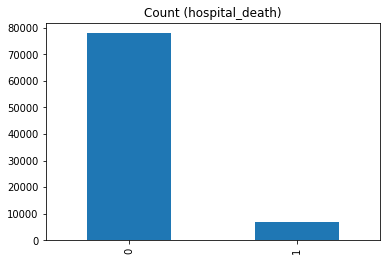

In [ ]:
print('Random under-sampling:')
print(df_training_test.hospital_death.value_counts())

df_training_test.hospital_death.value_counts().plot(kind='bar', title='Count (hospital_death)');

## **Treino**

**AUC - ROC Curve :**
AUC - ROC curve is a performance measurement for classification problem at various thresholds settings. ROC is a probability curve and AUC represents degree or measure of separability. It tells how much model is capable of distinguishing between classes. Higher the AUC, better the model is at predicting 0s as 0s and 1s as 1s. Higher the AUC, better the model is at distinguishing between patients with disease and no disease. The ROC curve is plotted with TPR against the FPR where TPR is on y-axis and FPR is on the x-axis.

In [ ]:
# creating independent features X and dependant feature Y
y = df_training_test['hospital_death']
X = df_training_test
X = df_training_test.drop('hospital_death',axis = 1)
test = df_unlabeled_test.drop('hospital_death',axis = 1)

# Split into training and validation set
X_train, valid_features, Y_train, valid_y = train_test_split(X, y, test_size = 0.20, random_state = 1)

#Balanceamento não efetivo
#X_train, Y_train = sm.fit_sample(X_train,Y_train)
pd.Series(Y_train).value_counts()

0    62255
1     5733
Name: hospital_death, dtype: int64

In [ ]:
GBC = GradientBoostingClassifier(random_state=1)

# Random Forest Classifier
RFC = RandomForestClassifier(n_estimators=100)

# Voting Classifier with soft voting 
votingC = VotingClassifier(estimators=[('rfc', RFC),('gbc',GBC)], voting='soft')
votingC = votingC.fit(X_train, Y_train)

predict_y = votingC.predict(valid_features)

## **Avaliação do Modelo**

In [ ]:
df_training_test.shape

(84986, 144)

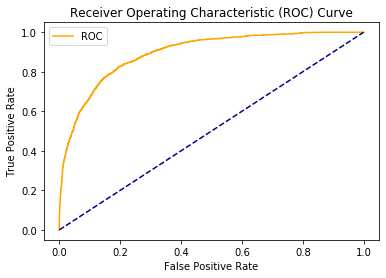

AUC-ROC : 0.8946430728587804


In [ ]:
probs = votingC.predict_proba(valid_features)
probs = probs[:, 1]
auc = roc_auc_score(valid_y, probs)
fpr, tpr, thresholds = roc_curve(valid_y, probs)
plot_roc_curve(fpr, tpr)
print("AUC-ROC :",auc)
#BEST: 0.8800656930938622
#KAGLE 0.88885
#      0.8809717064380203
#      0.8830800209264859
#      0.8881351711265832
#      0.8898505583260111 Retirando o tratamento de probabilidade_apache3 que eu tinha aplicado no início e gerando um modelo enviesádo (40 features)
#      0.8938572384537948 Inclui 143 features
#      0.8946430728587804

In [ ]:
#Acuraria
from sklearn import metrics
print(metrics.accuracy_score(valid_y,predict_y))
#Before 0.9208994407031161
#       0.9253000537409686
#       0.928955223880597
#       0.9319331686080715
#       0.9331097776208965
#       0.9334039298741028

0.9334039298741028


In [ ]:
#Acuracia Nula
acc = int(valid_y.value_counts()[0])
acc_null = int(valid_y.value_counts()[1])

print(acc/(acc+acc_null))
#Before 0.8995548453372902
#       0.9046396369499015 
#       0.9053731343283582
#       0.9191081303682787
#       0.9191081303682787

0.9191081303682787


[[15446   177]
 [  955   420]]


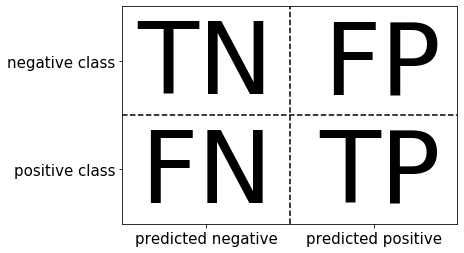

In [ ]:
mglearn.plots.plot_binary_confusion_matrix()

print(metrics.confusion_matrix(valid_y,predict_y))
#[[14986   164]
#[ 1076   521]]

#[[2825   50]
#[ 221  133]]

#[[15448   175]
# [  982   393]]

#[[15441   182]
# [  955   420]]

In [ ]:
confusion = metrics.confusion_matrix(valid_y,predict_y)
TP = confusion[1,1]
TN = confusion[0,0]
FP = confusion[0,1]
FN = confusion[1,0]

In [ ]:
#Acuracia de classificação
print(metrics.accuracy_score(valid_y,predict_y))
#Before: 0.9208994407031161
#        0.9253000537409686
#        0.928955223880597
#        0.9319331686080715

0.9334039298741028


In [ ]:
#Sensibilidade para óbitos
print(metrics.recall_score(valid_y,predict_y))
#Before 0.32329545454545455
#       0.32435817157169694
#       0.33753943217665616

0.3054545454545455


In [ ]:
#Especificidade
print(TN/(TN+FP))
#Before 0.9876284735439665
#       0.9886468646864687
#       0.9907682162875041

0.9886705498303783


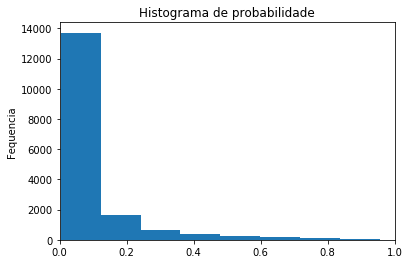

In [ ]:
plt.hist(probs, bins=8)
plt.xlim(0,1)
plt.title("Histograma de probabilidade")
plt.ylabel("Fequencia")
plt.show()

In [ ]:
df_unlabeled_test = df_unlabeled_test.fillna(df_unlabeled_test.mean())

In [ ]:
test = df_unlabeled_test.drop('hospital_death',axis = 1)
test1 = test.copy()
test1["hospital_death"] = votingC.predict_proba(test)[:,1]
test1[["encounter_id","hospital_death"]].to_csv("submission1.12.csv",index=False)
test1[["encounter_id","hospital_death"]].head()
#0  2	  0.06633578223210884
#1	5	  0.04805582613668505
#2	7	  0.02111677425951491
#3	8	  0.13188982587360878
#4	10	0.2444088078109492

,encounter_id,hospital_death
0,2,0.060611
1,5,0.043988
2,7,0.015959
3,8,0.112667
4,10,0.379860


Random under-sampling:
0    77878
1     7108
Name: hospital_death, dtype: int64


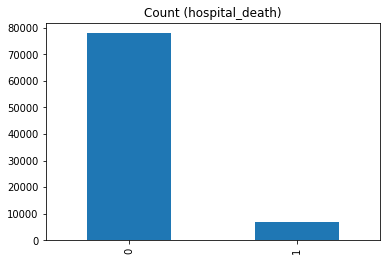

In [ ]:
print('Random under-sampling:')
print(df_training_test.hospital_death.value_counts())

df_training_test.hospital_death.value_counts().plot(kind='bar', title='Count (hospital_death)');